<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/influence_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
### PROCEDURE ###

# Step 1: Train a model on the 10-class MNIST dataset
# Step 2: Arbitrarily select a wrongly-classified test point, z_test
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z
# Step 4: Select the 500 training points with the largest |I_up,loss(z, z_test)|
# Step 5: Compute the actual change in test loss after removing the point and
#         retraining for each of the 500 points
# Step 6: Plot -1/n (I_up,loss(z, z_test)) vs. actual change in test loss for
#         each of the 500 points

In [49]:
# Step 2: Arbitrarily select a wrongly-classified test point, z_test

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import grad
from torch.autograd.functional import hvp
from torch.utils.data import Subset

In [2]:
# data is torch.FloatTensor; shape = (1, 28, 28)
# load train data: 60,000 samples
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

#loading test data: 10,000 samples
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 30963544.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3468452.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8610454.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7810794.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_dataset[index]
    elif dataset == 'test':
        return test_dataset[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_dataset[index][0].numpy().reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.show()
    elif dataset == 'test':
        img = test_dataset[index][0].numpy().reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.show()

In [4]:
# load train and test data samples into dataloader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# custom module for logistic regression
class LRModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(n_inputs, n_outputs)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [11]:
# instantiate the model
n_inputs = 28*28
n_outputs = 10
model = LRModel(n_inputs, n_outputs)
model.load_state_dict(torch.load('model_weights.pth'))

<ipython-input-11-ac56d928a54d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [12]:
def find_misclassified_indices(model=model, test_dataset=test_dataset):
  ''' returns a list of indices of all incorrectly labeled test points '''
  model.eval()
  indices = []
  for i in range(len(test_dataset)):
    image, label = get_item(i, dataset='test')
    image = image.view(-1, 28*28)
    with torch.no_grad():
      y_pred = model(image)
      _, predicted = torch.max(y_pred.data, 1)
      if predicted != label:
        indices.append(i)
  return indices

mislabeled_indices = find_misclassified_indices()

In [ ]:
# print(random.choice(mislabeled_indices))

3476


predicted value:  tensor([8])
actual value:  tensor([3])


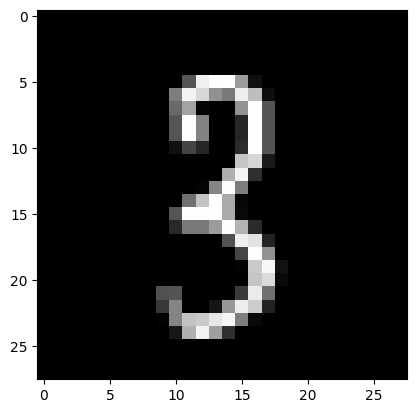

In [13]:
# loss function
loss_fn = nn.CrossEntropyLoss()

image, label = get_item(3476, dataset='test')
y_pred = model(image.view(-1, 28*28))
_, predicted = torch.max(y_pred.data, 1)

# z_test
z_test = image.view(-1, 28*28)
z_test_label = torch.tensor([test_dataset[3476][1]])

print("predicted value: ", predicted)
print("actual value: ", z_test_label)
show_image(3476, dataset='test')

In [14]:
# Step 3: Compute the influence I_up,loss(z, z_test) for every training point z

In [15]:
# get gradient of loss wrt params to kick off LiSSA
def compute_v(model, z_test, z_test_label, loss_fn):
    model.zero_grad()
    output = model(z_test)
    loss = loss_fn(output, z_test_label)

    v = grad(loss, model.parameters())
    return v

# returns list of torch tensors containing product of Hessian and v.
def hvp(y, w, v):
    # First backprop: Compute the gradient of y with respect to w
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(first_grads, v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop: Compute gradient of elementwise product with respect to w
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

# Precompute s_test using stochastic estimation, now using a mini-batch from the training data
def compute_s_test(model, z_test, v, loss_fn, scale=25, recursion_depth=5000, damping=0, batch_size=1, num_samples=10):
    model.eval()
    s_test = None

    for j in range(num_samples):
        print("Beginning of repeat #", j+1)
        h_estimate = v  # Start with the gradient of z_test

        for i in range(recursion_depth):
            # Sample a random mini-batch from the training data
            batch_indices = random.sample(range(len(train_dataset)), batch_size)
            train_batch = [train_dataset[i] for i in batch_indices]
            train_batch_inputs = torch.stack([x[0].view(-1, 28*28).squeeze() for x in train_batch])
            train_batch_labels = torch.tensor([x[1] for x in train_batch])

            model.zero_grad()
            output = model(train_batch_inputs)
            loss = loss_fn(output, train_batch_labels)

            # Compute the Hessian-vector product
            hv = hvp(loss, list(model.parameters()), h_estimate)

            # Recursively update h_estimate
            h_estimate = [
                _v + (1 - damping) * _h_e - _hv / scale
                for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]

            # Detach to prevent graph retention and memory buildup
            h_estimate = [h.detach() for h in h_estimate]

            if i%1000 == 0:
              print("Completed ", i, " iterations")

        if s_test is None:
            s_test = h_estimate
        else:
            s_test = [s + h for s, h in zip(s_test, h_estimate)]

    # Average over the number of samples
    s_test = [s / num_samples for s in s_test]

    return s_test

In [16]:
v = compute_v(model, z_test, z_test_label, loss_fn)
s_test = compute_s_test(model, z_test, v, loss_fn)

Beginning of repeat # 1
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 2
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 3
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 4
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 5
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 6
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Beginning of repeat # 7
Completed 

In [17]:
# returns a list where the ith index is the value of the influence for index i
# of the training set
def compute_influence(model, train_dataset, s_test, loss_fn):
    model.eval()

    # List to store influence scores for each training point
    influence_scores = []

    # Loop over each data point in the training set
    for z in train_dataset:
        # Extract input and label from training dataset point
        z_input = z[0].view(-1, 28*28)
        z_label = torch.tensor([z[1]])

        # Compute the gradient of the loss of the training point wrt the model parameters (v)
        v = compute_v(model, z_input, z_label, loss_fn)

        # Now compute the dot product between s_test and v
        influence = 0
        for s, v_i in zip(s_test, v):
            influence += torch.sum(s * v_i)

        # Store the negative of the influence as we want -s_test . v
        influence_scores.append(-influence.item())  # Append scalar value to the list

    return influence_scores


In [18]:
influence_scores = compute_influence(model, train_dataset, s_test, loss_fn)

In [19]:
def select_top_influential_points(influence_scores, top_n=500):
    # Create a dictionary mapping index i to the influence score
    influence_dict = {i: influence_scores[i] for i in range(len(influence_scores))}

    # Sort the dictionary by the absolute value of the influence scores in descending order
    sorted_influences = sorted(influence_dict.items(), key=lambda item: abs(item[1]), reverse=True)

    # Select the top N most influential points
    top_influential_dict = dict(sorted_influences[:top_n])

    return top_influential_dict

In [20]:
top_influential_dict = select_top_influential_points(influence_scores)
print(len(top_influential_dict))

500


In [21]:
print(top_influential_dict)

{27838: -1888.504638671875, 27795: -1807.0599365234375, 34140: -1707.6995849609375, 8708: -1669.60693359375, 48806: -1505.1011962890625, 26305: -1502.1468505859375, 3358: -1496.95361328125, 47207: -1468.4534912109375, 21182: -1443.5009765625, 25266: -1427.6785888671875, 49968: -1421.75048828125, 6398: -1418.408935546875, 25346: -1411.9080810546875, 35498: -1403.72509765625, 13656: -1382.3291015625, 48922: -1369.3443603515625, 18007: -1356.2271728515625, 9255: -1349.0557861328125, 58379: -1343.884033203125, 32031: -1323.140869140625, 33371: -1322.9954833984375, 15869: -1318.0118408203125, 52740: -1317.9273681640625, 49018: -1317.3077392578125, 48930: -1308.36962890625, 12546: -1300.30419921875, 56305: -1286.64892578125, 29670: -1275.9942626953125, 13488: -1266.1116943359375, 34846: -1258.08935546875, 33763: -1255.1480712890625, 40620: -1247.1812744140625, 22404: -1245.2318115234375, 24205: -1240.5933837890625, 16019: -1238.83740234375, 22459: -1233.349609375, 46329: -1231.065673828125, 

predicted value:  tensor([8])
actual value:  tensor([3])


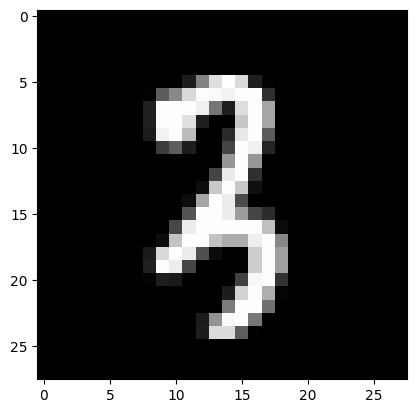

In [22]:
# example of a negatively influential example

image, label = get_item(27838)
y_pred = model(image.view(-1, 28*28))
_, predicted = torch.max(y_pred.data, 1)

# z_test
z_test = image.view(-1, 28*28)
z_test_label = torch.tensor([train_dataset[27838][1]])

print("predicted value: ", predicted)
print("actual value: ", z_test_label)
show_image(27838)

predicted value:  tensor([7])
actual value:  tensor([3])


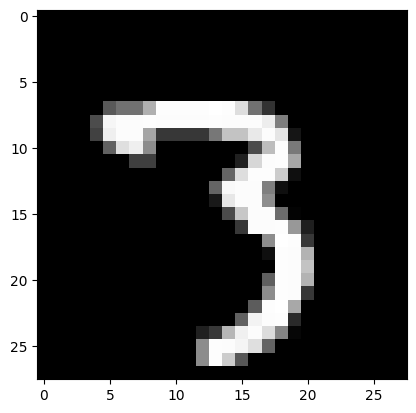

In [23]:
# example of a positively influential example

image, label = get_item(4866)
y_pred = model(image.view(-1, 28*28))
_, predicted = torch.max(y_pred.data, 1)

# z_test
z_test = image.view(-1, 28*28)
z_test_label = torch.tensor([train_dataset[4866][1]])

print("predicted value: ", predicted)
print("actual value: ", z_test_label)
show_image(4866)

In [24]:
# define a training function
def train(model, epochs, training_loader, testing_loader, optimizer):
  losses = []
  accuracies = []

  for epoch in range(epochs):
      for i, (images, labels) in enumerate(training_loader):
          optimizer.zero_grad()
          outputs = model(images.view(-1, 28*28))
          loss = loss_fn(outputs, labels)

          loss.backward()
          optimizer.step()
      losses.append(loss.item())

      correct = 0
      for images, labels in testing_loader:
          outputs = model(images.view(-1, 28*28))
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum()
      accuracy = 100 * (correct.item()) / len(test_dataset)
      accuracies.append(accuracy)
      print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

In [25]:
def remove_element_from_dataset(dataset, remove_index):
    # Get the list of all indices except the one to be removed
    indices = list(range(len(dataset)))
    indices.pop(remove_index)

    # Create a new dataset as a subset using the remaining indices
    new_dataset = Subset(dataset, indices)

    return new_dataset

In [26]:
def leave_one_out_retrain(z_test, z_test_label, old_model=model, top_influential=top_influential_dict):
  # compute old test loss
  old_loss = loss_fn(old_model(z_test), z_test_label)

  change_in_test_loss = []
  old_model.eval()
  count = 0
  for idx, val in top_influential.items():
    new_train_dataset = remove_element_from_dataset(train_dataset, remove_index=idx)
    new_train_loader = DataLoader(dataset=new_train_dataset, batch_size=batch_size, shuffle=True)

    new_model = LRModel(n_inputs, n_outputs)
    count += 1
    print("Retraining model #", count)
    optimizer = optim.SGD(new_model.parameters(), lr=0.001)
    train(model=new_model, epochs=10, training_loader=train_loader, testing_loader=test_loader, optimizer=optimizer)
    new_loss = loss_fn(new_model(z_test), z_test_label)
    change_in_test_loss.append(new_loss - old_loss)

  return change_in_test_loss

In [27]:
# loss function
loss_fn = nn.CrossEntropyLoss()

image, label = get_item(3476, dataset='test')
y_pred = model(image.view(-1, 28*28))
_, predicted = torch.max(y_pred.data, 1)

# z_test
z_test = image.view(-1, 28*28)
z_test_label = torch.tensor([test_dataset[3476][1]])

In [28]:
change_in_test_loss = leave_one_out_retrain(z_test, z_test_label)

Retraining model # 1
Epoch: 0. Loss: 2.2016775608062744. Accuracy: 57.49
Epoch: 1. Loss: 2.1185696125030518. Accuracy: 72.59


KeyboardInterrupt: 